# Convolutional Autoencoder for segmentation

In [1]:
import keras
from keras import models
from keras.layers import Dense, Dropout, Flatten, Activation, Lambda, Conv2D, MaxPooling2D, UpSampling2D
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization

from data_utils import *
import matplotlib.pyplot as plt
import numpy as np
import os
import time

Using TensorFlow backend.


# Load Data

In [2]:
x_train = np.load('./dataset/x_train.npy')
y_train = np.load('./dataset/y_train.npy')
x_test = np.load('./dataset/x_test.npy')
y_test = np.load('./dataset/y_test.npy')

# data already preprocessed
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(213, 64, 64, 1) (213, 64, 64, 1)
(54, 64, 64, 1) (54, 64, 64, 1)


# Segmentation Class using Convolutional Autoencoder

In [3]:
class SegCAE(object):
    def __init__(self, img_shape, actf = 'relu',
        learning_rate = 0.001,  drop_rate = 0.5, do_batch_norm = False, do_drop = False):
        '''
        Arguments :
        
        img_shape - shape of input image (64, 64, 1)
        actf - activation function for network training
        learning_rate - learning rate for training
        drop_rate - dropout rate
        do_batch_norm - whether to run for batchnormalization
        do_drop - whether to run for dropout
        '''

        self.learning_rate = learning_rate
        self.actf = actf
        self.img_shape = img_shape
        self.drop_rate = drop_rate
        self.do_batch_norm = do_batch_norm
        self.do_drop = do_drop

        self.model = self.build_model()
    
    # just enter input function
    def cae_data_input(self, x):
        return x
    
    # input shape
    def cae_shape(self, input_shape):
        return (input_shape[0], input_shape[1], input_shape[2])
    
    
    # encoder part
    def encoding_path(self, model):    
        # encoder layer1
        model.add(Conv2D(16, (3,3), strides = 1,  padding = 'same', kernel_initializer = 'he_normal'))
        model.add(BatchNormalization()) if self.do_batch_norm else None
        model.add(Activation(self.actf))
        model.add(MaxPooling2D((2,2), strides = (2,2)))
        
        # encoder layer2
        model.add(Conv2D(32, (3,3), strides = 1,  padding = 'same', kernel_initializer = 'he_normal'))
        model.add(BatchNormalization()) if self.do_batch_norm else None
        model.add(Activation(self.actf))
        model.add(MaxPooling2D((2,2), strides = (2,2)))     
        
        # encoder layer 3
        model.add(Conv2D(64, (3,3), strides = 1,  padding = 'same', kernel_initializer = 'he_normal'))
        model.add(BatchNormalization()) if self.do_batch_norm else None
        model.add(Activation(self.actf))
        model.add(MaxPooling2D((2,2), strides = (2,2))) 
                  
        return model
                  
    # decoder part
    def decoding_path(self, model):
        # decoder layer1
        model.add(Conv2D(64, (3,3), strides = 1,  padding = 'same', kernel_initializer = 'he_normal'))
        model.add(BatchNormalization()) if self.do_batch_norm else None
        model.add(Activation(self.actf))
        model.add(UpSampling2D((2,2)))
        
        # decoder layer2
        model.add(Conv2D(32, (3,3), strides = 1,  padding = 'same', kernel_initializer = 'he_normal'))
        model.add(BatchNormalization()) if self.do_batch_norm else None
        model.add(Activation(self.actf))
        model.add(UpSampling2D((2,2)))
        
        # decoder layer3
        model.add(Conv2D(16, (3,3), strides = 1,  padding = 'same', kernel_initializer = 'he_normal'))
        model.add(BatchNormalization()) if self.do_batch_norm else None
        model.add(Activation(self.actf))
        model.add(UpSampling2D((2,2)))     
                  
        model.add(Conv2D(1, (3,3), strides = 1,  padding = 'same', kernel_initializer = 'he_normal'))
        model.add(Activation('sigmoid'))
        
        return model
    
    # build network
    def build_model(self):
        model = models.Sequential()
        
        #  input layer
        model.add(Lambda(self.cae_data_input, input_shape = self.img_shape))
        
        # encoding 
        model = self.encoding_path(model)
        
        # middle layer
        model.add(Conv2D(128, (3,3), strides = 1,  padding = 'same', kernel_initializer = 'he_normal'))
        model.add(Dropout(self.drop_rate)) if self.do_drop else None
        
        # decoding
        model = self.decoding_path(model)
        
        model.compile(loss = 'binary_crossentropy', optimizer = Adam(lr = self.learning_rate)
                          , metrics = [dice_coef])
        return model

    # train model
    def train(self, X_train, Y_train, epoch = 10, batch_size = 32, val_split = 0.2):
      
        self.history = self.model.fit(X_train, Y_train, validation_split = val_split, 
                                          epochs = epoch, batch_size = batch_size)
        return self.history
    
    # predict test data
    def predict(self, X_test):
        pred_classes = self.model.predict(X_test)

        return pred_classes
    
    # show model architecture
    def show_model(self):
        return print(self.model.summary())

create class 

In [4]:
seg_model = SegCAE(x_train[0].shape, do_batch_norm = True, do_drop = True)

In [5]:
seg_model.show_model() # show architecture of model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        160       
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 16)        64        
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
__________

# Train Model

In [6]:
history = seg_model.train(x_train, y_train, epoch = 100, batch_size = 64)

Train on 170 samples, validate on 43 samples
Epoch 1/100
170/170 [==============================] - 2s 13ms/step - loss: 0.6371 - dice_coef: 0.3655 - val_loss: 1.0562 - val_dice_coef: 0.4654
Epoch 2/100
170/170 [==============================] - 0s 286us/step - loss: 0.4370 - dice_coef: 0.5174 - val_loss: 0.7818 - val_dice_coef: 0.5383
Epoch 3/100
170/170 [==============================] - 0s 281us/step - loss: 0.3372 - dice_coef: 0.5916 - val_loss: 0.3734 - val_dice_coef: 0.6544
Epoch 4/100
170/170 [==============================] - 0s 272us/step - loss: 0.2770 - dice_coef: 0.6380 - val_loss: 0.2843 - val_dice_coef: 0.7021
Epoch 5/100
170/170 [==============================] - 0s 271us/step - loss: 0.2469 - dice_coef: 0.6642 - val_loss: 0.2671 - val_dice_coef: 0.7167
Epoch 6/100
170/170 [==============================] - 0s 277us/step - loss: 0.2238 - dice_coef: 0.6863 - val_loss: 0.2631 - val_dice_coef: 0.7225
Epoch 7/100
170/170 [==============================] - 0s 286us/step - los

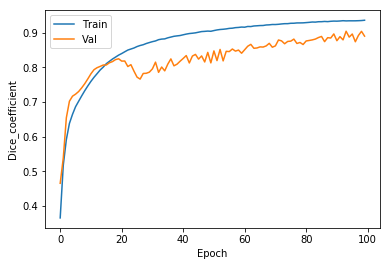

In [8]:
plot_dice(history)

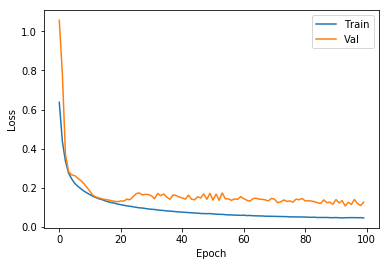

In [9]:
plot_loss(history)

# Show result

In [10]:
preds = seg_model.predict(x_test)

Original test data | true masked data | prediction data

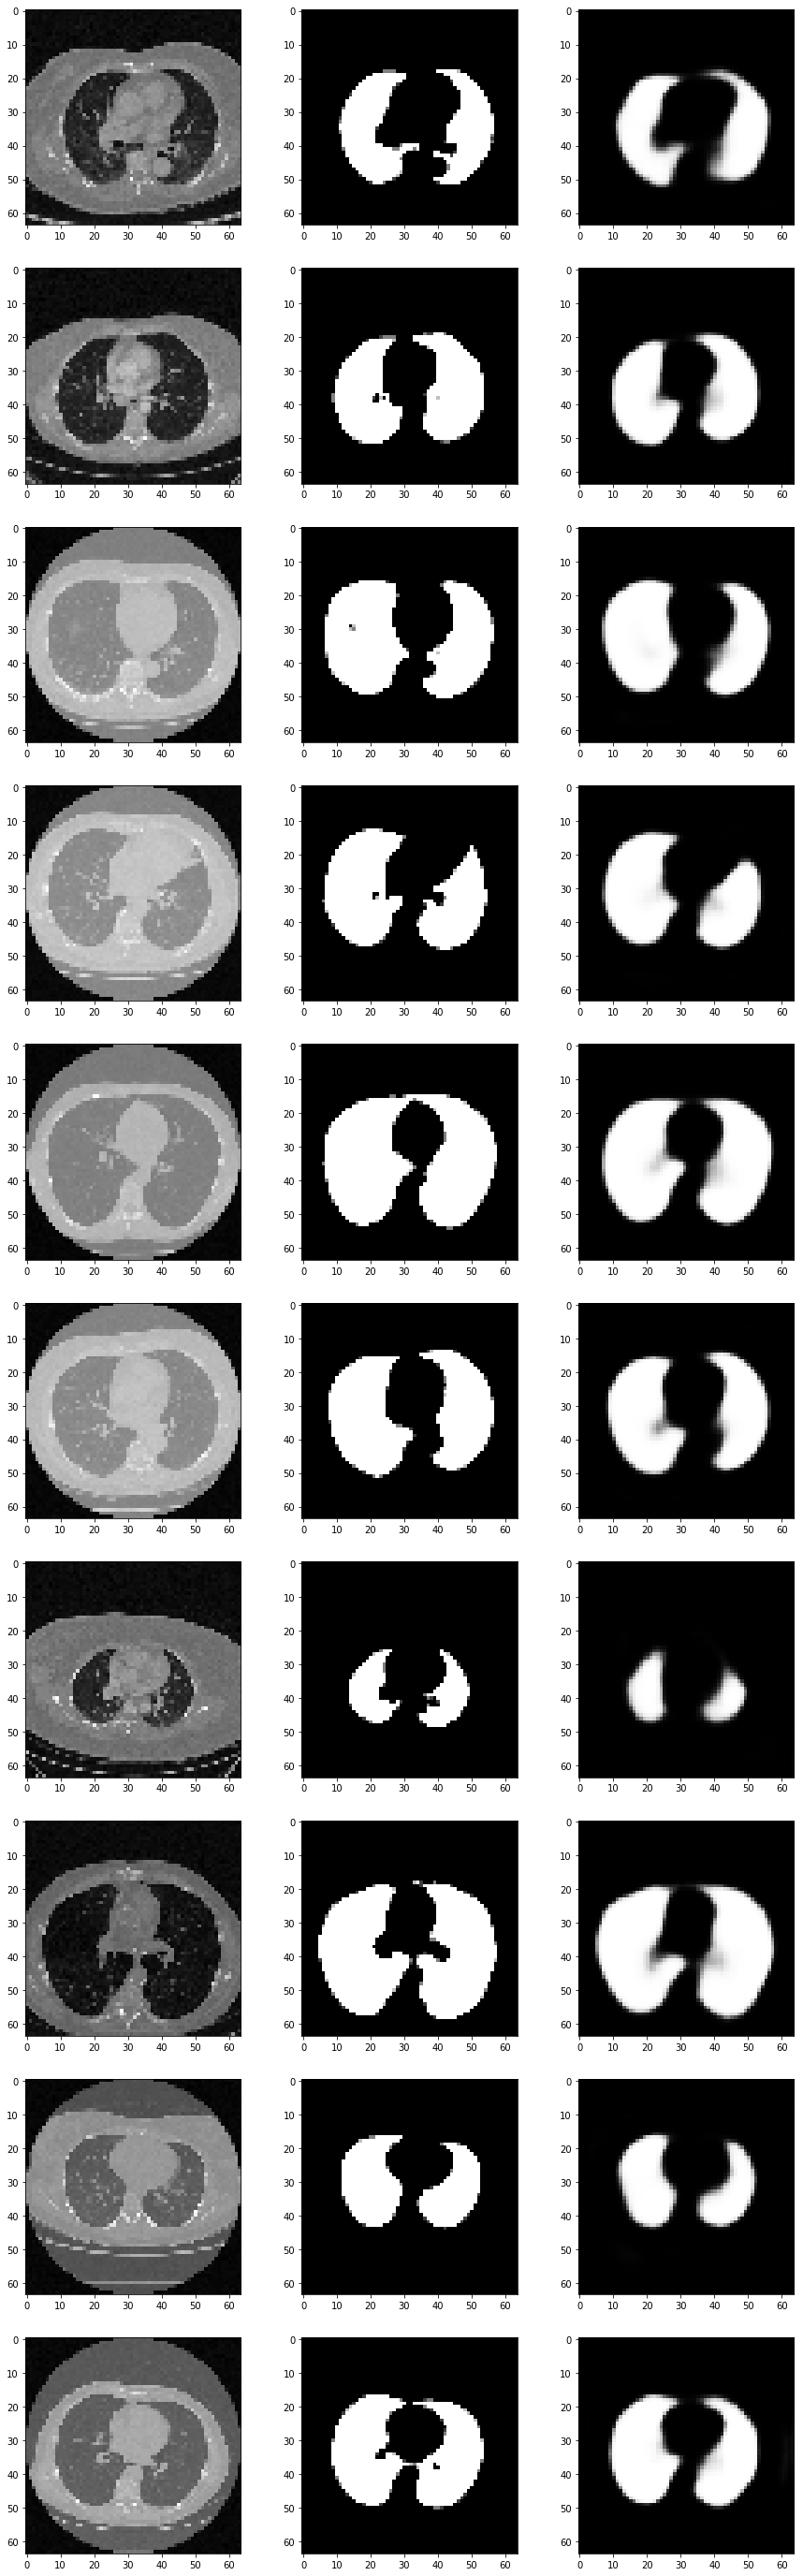

In [11]:
show_num = 10
fig, ax = plt.subplots(show_num, 3, figsize=(15, 50))

for i, pred in enumerate(preds[:show_num]):
    ax[i, 0].imshow(x_test[i].squeeze(), cmap='gray')
    ax[i, 1].imshow(y_test[i].squeeze(), cmap='gray')
    ax[i, 2].imshow(pred.squeeze(), cmap='gray')